# Isolation Forest Baseline

2026-01-18

Reproducing SKAB leaderboard. Their method: train on first 400 samples of each file (before fault), test on rest.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, confusion_matrix

plt.rcParams['figure.figsize'] = (14, 4)

In [10]:
data_dir = Path('../data/raw/SKAB/data')

files = []
for folder in ['valve1', 'valve2', 'other']:
    files.extend(sorted((data_dir / folder).glob('*.csv')))

len(files)

34

In [11]:
def load_file(path):
    return pd.read_csv(path, sep=';', parse_dates=['datetime'], index_col='datetime')

feature_cols = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 
                'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

In [12]:
TRAIN_SIZE = 400
CONTAMINATION = 0.0005

all_y_true = []
all_y_pred = []

for f in files:
    df = load_file(f)
    X = df[feature_cols]
    y = df['anomaly']
    
    X_train, X_test = X.iloc[:TRAIN_SIZE], X.iloc[TRAIN_SIZE:]
    y_test = y.iloc[TRAIN_SIZE:]
    
    model = IsolationForest(contamination=CONTAMINATION, random_state=0, n_jobs=-1)
    model.fit(X_train)
    
    raw_pred = model.predict(X_test)
    pred = pd.Series(raw_pred * -1, index=X_test.index).rolling(3).median().fillna(0).replace(-1, 0)
    
    all_y_true.append(y_test)
    all_y_pred.append(pred)

In [13]:
y_true = pd.concat(all_y_true)
y_pred = pd.concat(all_y_pred)

f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
far = fp / (fp + tn) * 100
mar = fn / (fn + tp) * 100

print(f'F1:  {f1:.2f}  (SKAB: 0.29)')
print(f'FAR: {far:.2f}% (SKAB: 2.56%)')
print(f'MAR: {mar:.2f}% (SKAB: 82.89%)')

F1:  0.29  (SKAB: 0.29)
FAR: 2.56% (SKAB: 2.56%)
MAR: 82.89% (SKAB: 82.89%)


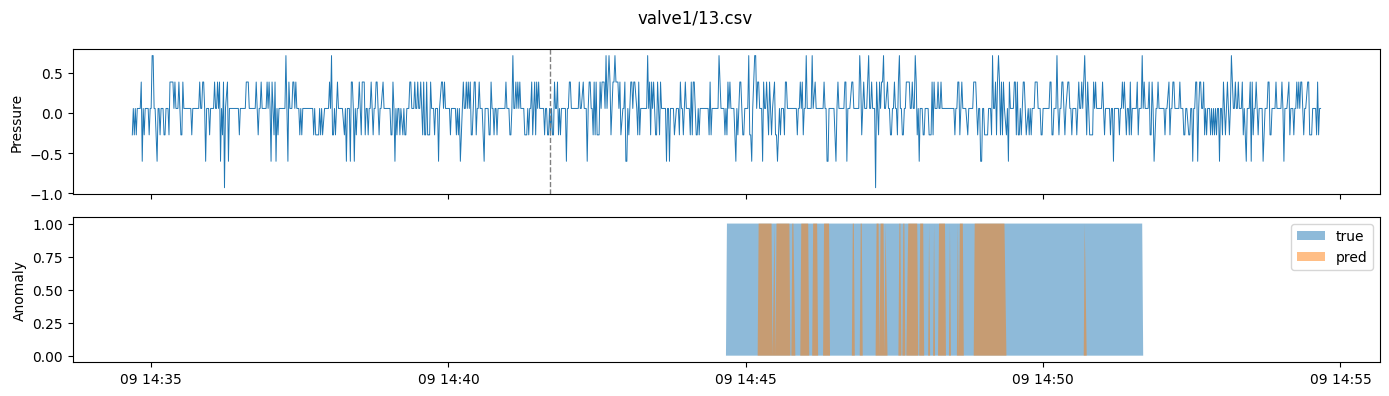

In [14]:
# visualize one file
idx = 5
sample = load_file(files[idx])
X_s = sample[feature_cols]

m = IsolationForest(contamination=CONTAMINATION, random_state=0, n_jobs=-1)
m.fit(X_s.iloc[:TRAIN_SIZE])
pred = pd.Series(m.predict(X_s.iloc[TRAIN_SIZE:]) * -1, index=X_s.iloc[TRAIN_SIZE:].index)
pred = pred.rolling(3).median().fillna(0).replace(-1, 0)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(sample['Pressure'], lw=0.7)
ax[0].axvline(sample.index[TRAIN_SIZE], color='gray', ls='--', lw=1)
ax[0].set_ylabel('Pressure')

ax[1].fill_between(sample.iloc[TRAIN_SIZE:].index, sample['anomaly'].iloc[TRAIN_SIZE:], alpha=0.5, label='true')
ax[1].fill_between(pred.index, pred, alpha=0.5, label='pred')
ax[1].legend()
ax[1].set_ylabel('Anomaly')
plt.suptitle(f'{files[idx].parent.name}/{files[idx].name}')
plt.tight_layout()

In [15]:
import pickle
print(f'Model size: {len(pickle.dumps(m))/1024:.0f} KB')

Model size: 1288 KB


In [16]:
import time

# single sample inference (average over 1000 runs)
single_sample = X_s.iloc[[TRAIN_SIZE]]
times = []
for _ in range(1000):
    t0 = time.perf_counter()
    m.predict(single_sample)
    times.append(time.perf_counter() - t0)

avg_single = np.mean(times) * 1000
med_single = np.median(times) * 1000
print(f'Single sample: {avg_single:.2f} ms avg, {med_single:.2f} ms median')

# full test file inference
test_data = X_s.iloc[TRAIN_SIZE:]
times_batch = []
for _ in range(100):
    t0 = time.perf_counter()
    m.predict(test_data)
    times_batch.append(time.perf_counter() - t0)

avg_batch = np.mean(times_batch) * 1000
print(f'Full file ({len(test_data)} samples): {avg_batch:.2f} ms avg')

Single sample: 5.07 ms avg, 4.43 ms median
Full file (740 samples): 7.10 ms avg


---

Baseline complete (accuracy + size + latency). Next: autoencoder.